# Computational Exercise 2: Classification with MNIST

*Applied Data Science; July 8, 2019*

**Please note that this exercise is intended to be completed in groups, and may be difficult to complete individually.**

**Due:** *Thursday, June 20 at 11:59pm*

---
In this exercise, we'll explore classification of handwritten digits from the MNIST dataset with three different models:

1. Logistic Regression
2. Multilayer Perceptron
3. Convolutional Neural Network

Goals of the exercise are as follows:

- Gain further practice working with train, validation, and test partitions
- Observe how these models can be coded in Tensorflow (for those interested in developing their own models)
- Observe that the CNN is more effective than a simple MLP for this task, which is in turn more effective than logistic regression
- Visualize (a) the logistic regression filters for each digit, and (b) the layer 1 filters learned by the CNN
- Explore training versus validation accuracy and design your own early stopping procedure

As usual, we'll begin by importing required libraries:

- numpy for efficient math operations
- pandas for data and dataframe manipulations
- tensorflow for defining and training our models
- matplotlib for visualization/plotting
- tqdm to see training progress

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange

Next, we'll load the MNIST dataset. The data are already broken down into:

1. a development set, which we'll further divide into a training set and a validation set; and 
2. a test set.

The images are already ordered at random, so we don't need to shuffle them.

In [2]:
# Load MNIST
(x_dev, y_dev), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Divide development set into train and validation
x_train, x_val = x_dev[:50000], x_dev[50000:]
y_train, y_val = y_dev[:50000], y_dev[50000:]

print('There are', len(x_train), 'training images.')
print('There are', len(x_val), 'validation images.')
print('There are', len(x_test), 'test images.')

There are 50000 training images.
There are 10000 validation images.
There are 10000 test images.


Let's look at 10 example images from our training set. The code block below utilizes the `ax.imshow` method from matplotlib. **This code can be reused later in the exercise to visualize the learned filters in the logistic regression and CNN models**.

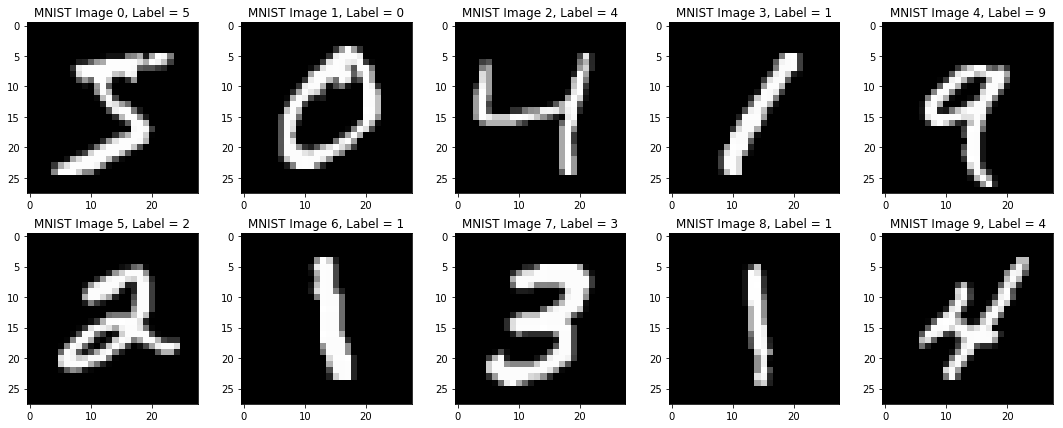

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i in range(10):
    ax[i // 5, i % 5].imshow(x_train[i, :, :], cmap='gray')
    ax[i // 5, i % 5].set_title('MNIST Image %i, Label = %i' % (i, y_train[i]), fontsize=12)
plt.tight_layout()
plt.show()

From the plots above, we can see that there are 3 ones in the first 10 training images. Let's look at the distribution of the labels across the whole training set to make sure that all 10 digits are equally represented, more or less. In this block, we'll use `np.unique()` to count the number of times each digit occurs within `y_train`, the labels for our training data.

In generating our plot, the important command is `plt.bar(y_train_values, y_train_counts)`, which plots a bar graph of the counts for each value of the labels. The remaining commands make the plot a little more readable.

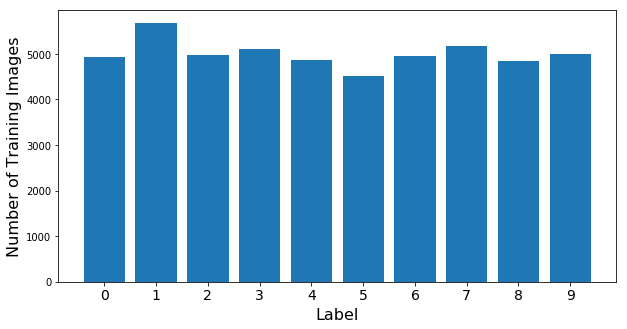

In [4]:
y_train_values, y_train_counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(y_train_values, y_train_counts)
plt.xticks(np.arange(10), fontsize=14)
plt.ylabel('Number of Training Images', fontsize=16)
plt.xlabel('Label', fontsize=16)
plt.show()

### Logistic Regression

Now, we'll define a logistic regression model and train it in tensorflow. **You are not responsible for understanding of the details in this block**, but it may be interesting for those with more coding background, or who are interested in developing their own models.

This block defines:
1. the model architecture
2. the cross-entropy loss
3. the optimizer to be used in training

In [5]:
# Define data placeholder and labels placeholder
x = tf.placeholder(tf.float32, [None, 28, 28])
y = tf.placeholder(tf.int32, [None])

# vectorize the input images
x_flat = tf.reshape(x, [-1, 28 * 28])

# create variables for the filters, one per digit
W = tf.Variable(tf.zeros([28 * 28, 10]))

# create biases terms
b = tf.Variable(tf.zeros([10]))

# define the log-odds as a function of the input, filters, and biases
z = tf.matmul(x_flat, W) + b

# we predict the label with highest log-odds
predictions = tf.math.argmax(z, axis=1)

# since the cross-entropy loss is so widely used, tensorflow has a convenient function implementing it
cross_entropy = tf.losses.sparse_softmax_cross_entropy(logits=z, labels=y)

# here we define our optimization algorithm (gradient descent)
train_step = tf.train.GradientDescentOptimizer(.01).minimize(cross_entropy)

### Train the Logistic Regression Model and Evaluate Performance on our Validation Set

In this block, we train our logistic regression model, evaluate its performance on the validation set after training is complete, and obtain the filter weights.

In [6]:
with tf.Session() as s:
    
    # initialize variables (weights and biases)
    s.run(tf.global_variables_initializer())
    
    # train for 1000 steps using gradient descent
    for i in trange(1000):
        
        # set indices for the current batch
        first = i * 100 % len(x_train)
        last = first + 100
        
        # take a step using gradient descent
        s.run(train_step, feed_dict={x: x_train[first:last], y: y_train[first:last]})
    
    # with training now complete, evaluate performance on the validation set
    weights, y_val_predicted = s.run([W, predictions], feed_dict={x: x_val, y: y_val})

# print results
print('Accuracy on the validation set is %.2f%%' % (100 * np.sum(y_val == y_val_predicted) / len(y_val)))

100%|██████████| 1000/1000 [00:00<00:00, 1414.00it/s]

Accuracy on the validation set is 89.41%


### Exercise 1a: visualize the learned filters

In the block below, the first line of code reshapes the logistic regression weights into 28 by 28 grids. This allows them to be viewed and interpreted as filters, as we have discussed in class. Specifically, `learned_filters[i, :, :]` is a 28 by 28 filter corresponding to digit `i`. For this exercise, please write code to visualize these filters. It may be helpful to reuse the code we used earlier to visualize our training data.

In [7]:
learned_filters = np.array([weights[:, i].reshape([28, 28]) for i in range(10)])

### YOUR CODE HERE ###

### Exercise 1b: describe the learned filters

In 1-2 paragraphs, please describe and explain the appearance of the learned filters using ideas discussed in class. Why do these filters look (somewhat) like the digits they have been tuned to detect? Why don't they look *more* like these digits, i.e. why are they blurry? Please respond below.

---

**YOUR RESPONSE HERE**

### Multilayer Perceptron

Next, we'll define a shallow multilayer perceptron model and train it in tensorflow. As before, **you are not responsible for understanding of the details in this block**, but it may be interesting for those with more coding background, or who are interested in developing their own models.

Similar to before, this block defines:
1. the model architecture
2. the cross-entropy loss
3. the optimizer to be used in training

We'll begin with an MLP with one hidden layer of 1024 units. This is specified at the end of the block.

In [8]:
def MLP(x, y, layers, learning_rate=1e-3):

    # Reshape the input
    h = tf.reshape(x, [-1, 28 * 28])

    # Add hidden layers
    for layer in layers:
        h = tf.contrib.layers.fully_connected(h, layer, activation_fn=tf.nn.sigmoid)

    # Add logit layer (no activation)
    z = tf.contrib.layers.fully_connected(h, 10, activation_fn=None)

    # We predict the class with max logit value
    predictions = tf.math.argmax(z, axis=1)

    # Define the logistic regression loss
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(logits=z, labels=y)

    # Define the optimizer
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
    
    return train_step, cross_entropy, predictions

# Set layers
layers = [1024]

# Use our MLP function to obtain our training step, cross entropy, and predictions tensors
train_step, cross_entropy, predictions = MLP(x, y, layers)

### Train the MLP and Evaluate Performance on our Validation Set

The code for training our MLP is the same as the code we used to train our logistic regression model, with the following exceptions:

- We are now tracking validation performance every 500 iterations. In principle, we could use this information for early stopping.
- We are training for many more steps (30000 in this case)

In [9]:
val_acc = []

with tf.Session() as s:
    
    s.run(tf.global_variables_initializer())
    
    for i in trange(30000):
        
        first = i * 100 % len(x_train)
        last = first + 100
        
        s.run(train_step, feed_dict={x: x_train[first:last], y: y_train[first:last]})
        
        if i % 500 == 0:
            
            y_val_predicted = s.run(predictions, feed_dict={x: x_val})
            val_acc.append(sum(y_val_predicted == y_val) / len(y_val))
            
    # with training now complete, evaluate performance on the validation set
    y_val_predicted = s.run(predictions, feed_dict={x: x_val, y: y_val})

# print results
print('Final accuracy on the validation set is %.2f%%' % (100 * np.sum(y_val == y_val_predicted) / len(y_val)))
plt.plot(val_acc[25:])
plt.show()

100%|██████████| 30000/30000 [04:14<00:00, 117.90it/s]


Final accuracy on the validation set is 96.25%


### Exercise 2a: MLP performance

In 1-2 paragraphs, please describe how the MLP's final accuracy on the validation set compares to that of our previous, logistic regression model. Using ideas from class, discuss why this might be the case. Please respond below.

---

**YOUR RESPONSE HERE**

### Exercise 2b: MLP exploration

In the code block below, either (a) specify an alternative MLP architecture, or (b) make a minor modification to the training procedure (e.g. change the optimizer, number of training steps, or learning rate). After training is complete, evaluate your model's final performance on the validation set. In 1 paragraph, describe how your model's performance compares to the previous MLP, and speculate as to why this might be the case. Please respond below.

--- 

**YOUR RESPONSE HERE**

In [ ]:
### MODIFY THIS BLOCK IN EXERCISE 2b ###

# Set layers
layers = [1024]

# Use our MLP function to obtain our training step, cross entropy, and predictions tensors
train_step, cross_entropy, predictions = MLP(x, y, layers)

val_acc = []

with tf.Session() as s:
    
    s.run(tf.global_variables_initializer())
    
    for i in trange(30000):
        
        first = i * 100 % len(x_train)
        last = first + 100
        
        s.run(train_step, feed_dict={x: x_train[first:last], y: y_train[first:last]})
        
        if i % 500 == 0:
            
            y_val_predicted = s.run(predictions, feed_dict={x: x_val})
            val_acc.append(sum(y_val_predicted == y_val) / len(y_val))
            
    # with training now complete, evaluate performance on the validation set
    y_val_predicted = s.run(predictions, feed_dict={x: x_val, y: y_val})

# print results
print('Final accuracy on the validation set is %.2f%%' % (100 * np.sum(y_val == y_val_predicted) / len(y_val)))

### MODIFY THIS BLOCK IN EXERCISE 2b ###

### (optional) Convolutional Neural Network

**The following material is optional.**

Finally, we'll define and train a shallow CNN. As before, **you are not responsible for understanding of the details in this block**, but it may be interesting for those with more coding background, or who are interested in developing their own models.

Again, this block defines:
1. the model architecture
2. the cross-entropy loss
3. the optimizer to be used in training

Our CNN consists of the following layers:

- convolutional layer 1
- max-pooling layer 1
- convolutional layer 2
- max-pooling layer 2
- a fully-connected layer with 1024 hidden units
- a log-odds layer with 10 units, one per digit

In [7]:
def shallow_CNN(x, y, learning_rate=1e-3):
    """Model function for CNN."""
    # Input Layer
    input_layer = x[:, :, :, tf.newaxis]

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu,
      name='conv1')

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    # Logits Layer
    z = tf.layers.dense(inputs=dense, units=10)
    
    # We predict the class with max logit value
    predictions = tf.math.argmax(z, axis=1)

    # Calculate Loss (for both TRAIN and EVAL modes)
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=z)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

    return train_step, cross_entropy, predictions

In [8]:
# get the training step, cross entropy, and predictions for our shallow CNN
train_step, cross_entropy, predictions = shallow_CNN(x, y)

# get the tensor corresponding to our level 1 filters (32 filters, 5x5 each)
conv1_filters = tf.squeeze(tf.get_default_graph().get_tensor_by_name('conv1/kernel:0'))

### (optional) Exercise 3: CNN exploration

Run the code block below to train the shallow CNN. You will need to train for at least 30000 steps. Even though this is a shallow architecture, training will require GPU resources (or it will be very slow). If you are successful, report your performance on the validation set and/or modify the code below to evaluate performance on the test set. Then, visualize the 32 layer 1 filters (5x5 each) using code similar to that used in Exercise 1a. In the code block below, these filters will be collected as `conv1_filters_trained`. Report your findings below.

---

**YOUR RESPONSE HERE**

In [12]:
val_acc = []

with tf.Session() as s:
    
    s.run(tf.global_variables_initializer())
    
    for i in trange(30000):
        
        first = i * 100 % len(x_train)
        last = first + 100
        
        s.run(train_step, feed_dict={x: x_train[first:last], y: y_train[first:last]})
        
        if i % 500 == 0:
            
            y_val_predicted = s.run(predictions, feed_dict={x: x_val})
            val_acc.append(sum(y_val_predicted == y_val) / len(y_val))
            
    # with training now complete, evaluate performance on the validation set
    y_val_predicted, conv1_filters_trained = s.run(
        [predictions, conv1_filters], feed_dict={x: x_val, y: y_val})

# print results
print('Accuracy on the validation set is %.2f%%' % (100 * np.sum(y_val == y_val_predicted) / len(y_val)))

  6%|▌         | 1700/30000 [07:15<1:55:38,  4.08it/s] 

KeyboardInterrupt: 